## Libraries

In [2]:
from IPython.display import clear_output
!pip install torch
!pip install torchvision
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install cleverhans
!pip install cachetools
!pip install pandas==1.3.4
!pip install foolbox
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
clear_output()

In [3]:
import os,itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import gc
import matplotlib.pyplot as plt

In [4]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import models, transforms
from load_diabetic import load_diabetic_data
from load_skin import load_skin_data

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [6]:
train_loader, val_loader = load_skin_data()
print(len(train_loader))

2248


## Model

In [7]:
from torch import optim,nn

num_classes = 7

In [8]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
model = model_ft.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

### Training

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0);
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        if (i + 1) % 100 == 0:
            print('[train loss %.5f], [train acc %.5f]' % (train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    print('[Train loss %.5f], [Train acc %.5f]' % (total_loss_train[-1], total_acc_train[-1]))

In [14]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            gc.collect()
            torch.cuda.empty_cache()
            images, labels = data
            N = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')

In [15]:


epochs = 4

for i in range(epochs):
    gc.collect()
    torch.cuda.empty_cache()
    print(i)
    train(train_loader, model, criterion, optimizer)
    print("Training Done")
    validate(val_loader, model, criterion, optimizer, i)

0
[train loss 0.88797], [train acc 0.67688]
[Train loss 0.88797], [Train acc 0.67688]
Training Done
------------------------------------------------------------
[epoch 0], [val loss 0.67871], [val acc 0.73719]
------------------------------------------------------------
1
[train loss 0.59822], [train acc 0.77563]
[Train loss 0.59822], [Train acc 0.77563]
Training Done
------------------------------------------------------------
[epoch 1], [val loss 0.54804], [val acc 0.82046]
------------------------------------------------------------
2
[train loss 0.52878], [train acc 0.80625]
[Train loss 0.52878], [Train acc 0.80625]
Training Done
------------------------------------------------------------
[epoch 2], [val loss 0.54124], [val acc 0.80377]
------------------------------------------------------------
3
[train loss 0.50016], [train acc 0.81250]
[Train loss 0.50016], [Train acc 0.81250]
Training Done
------------------------------------------------------------
[epoch 3], [val loss 0.514

In [16]:
torch.save(model, 'model/model_diabetic_exploration.pth')

In [8]:
model = torch.load('model/skin/model_skin.pth')
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Attacks

In [9]:
from IPython.display import clear_output
!pip install captum
!pip install cleverhans
!pip install -U numba
clear_output()

In [10]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import visualization as viz
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [11]:
ep = [4/255, 8/255, 16/255, 32/255]

In [24]:
def validate_attack(val_loader, model, eps, algorithm):
    model.eval()
    val_acc = AverageMeter()
    dataiter = iter(val_loader)
    
    for i in range(len(val_loader)):
        gc.collect()
        torch.cuda.empty_cache()
        images, labels = next(dataiter)
        images = images.to(device)
        labels = labels.to(device)
        for ind in range(len(images)):
            input = images[ind].unsqueeze(0)
            
            if algorithm == "pgd":
                    alpha = eps/10
                    steps = 5
                    input = projected_gradient_descent(model, input, eps, alpha, steps, np.inf)
            elif algorithm == "fgsm":
                input = fast_gradient_method(model, input, eps, np.inf)
            elif algorithm == "bim":
                alpha = eps/10
                steps = 5
                input = projected_gradient_descent(model, input, eps, alpha, steps, np.inf, rand_init=False)
                    
            _, prediction = model(input).max(1)
            
            val_acc.update(prediction.eq(labels[ind].view_as(prediction)).sum().item())
            
            

    print('------------------------------------------------------------')
    print('[val acc %.5f]' % (val_acc.avg))
    print('------------------------------------------------------------')

In [28]:
for eps in ep:
    validate_attack(val_loader, model, eps, "fgsm")

------------------------------------------------------------
[val acc 0.20490]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.13690]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.15231]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.44424]
------------------------------------------------------------


In [29]:
for eps in ep:
    validate_attack(val_loader, model, eps, "pgd")

------------------------------------------------------------
[val acc 0.13509]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.05168]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.05077]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.05440]
------------------------------------------------------------


In [30]:
for eps in ep:
    validate_attack(val_loader, model, eps, "bim")

------------------------------------------------------------
[val acc 0.09429]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.04986]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.05077]
------------------------------------------------------------
------------------------------------------------------------
[val acc 0.05077]
------------------------------------------------------------


## Statistical Methods

In [12]:
from main import compute_mean_abs_dev, compute_median_abs_dev, compute_iqr

In [13]:
import torch.nn.functional as F

def gradient(model, x, target):
    input = x.unsqueeze(0)
    if target is None:
        _, target = model(input).max(1)
    xai = Saliency(model)
    return xai.attribute(input, target=target, abs=True)[0]

In [14]:
def ig(model, x, target):
    input = x.unsqueeze(0)
    if target is None:
        _, target = model(input).max(1)
    xai = IntegratedGradients(model)
    return xai.attribute(input, target=target)[0]

In [15]:
def m1(model, x, target):
    grad = gradient(model, x, target)
    input = x * grad
    input = input.detach()
    return gradient(model, input, target)

In [16]:
def m2(model, x, alpha, target):
    grad = gradient(model, x, target)
    input = x + alpha * grad
    input = input.detach()
    return gradient(model, input, target)

In [ ]:
count = 0
ind = 3
for i, data in enumerate(val_loader):
    images, labels = data
    input = images[ind]
    _, y = model(input.unsqueeze(0)).max(1)
    grad = gradient(model, input, y)
    grad = np.array(grad).flatten()
    input = fast_gradient_method(model, input.unsqueeze(0), ep[0], np.inf)[0]
    _, y = model(input.unsqueeze(0)).max(1)
    grad_adv = gradient(model, input, y)
    grad_adv = np.array(grad_adv).flatten()
    plt.hist(grad, label='Benign', color='blue')
    plt.hist(grad_adv, label='FGSM 8/255',color='red', alpha=0.7)
    plt.show()
    count+=1
    if count == 3: 
        break

In [ ]:
count = 0
ind = 3
for i, data in enumerate(val_loader):
    images, labels = data
    input = images[ind]
    _, y = model(input.unsqueeze(0)).max(1)
    grad = m2(model, input, 2, y)
    plt.imshow(grad.permute(1, 2, 0))
    plt.show()
    input = fast_gradient_method(model, input.unsqueeze(0), ep[0], np.inf)[0]
    _, y = model(input.unsqueeze(0)).max(1)
    grad = m2(model, input, 2, y)
    plt.imshow(grad.permute(1, 2, 0))
    plt.show()
    count+=1
    if count == 3: 
        break

## Results

In [17]:
from main import topk

def run(model, val_loader, eps, attack, defense):
    gc.collect()
    torch.cuda.empty_cache()
    
    dataiter = iter(val_loader)
    
    meanAbs_bena = []
    meanAbs_ben = []
    
    for i in range(len(val_loader)):
        images, labels = next(dataiter)
        images = images.to(device)
        labels = labels.to(device)
        for ind in range(len(images)):
            gc.collect()
            torch.cuda.empty_cache()
            input = images[ind]
            
            _, y = model(input.unsqueeze(0)).max(1)
            
            if defense == "m1":
                ben = gradient(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m2":
                ben = ig(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m4":
                ben = m1(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m3":
                ben = m2(model, input, 1, y).sum(axis=1).cpu().detach().numpy()
            
            temp = []
            temp.append(ben)
            meanAbs_ben += compute_mean_abs_dev(temp)
            
            if attack == "pgd":
                alpha = eps/10
                steps = 20
                input = projected_gradient_descent(model, input.unsqueeze(0), eps, alpha, steps, np.inf)[0]
            elif attack == "fgsm":
                input = fast_gradient_method(model, input.unsqueeze(0), eps, np.inf)[0]
            elif attack == "bim":
                alpha = eps/10
                steps = 20
                input = projected_gradient_descent(model, input.unsqueeze(0), eps, alpha, steps, np.inf, rand_init=False)[0]
            
            _, y = model(input.unsqueeze(0)).max(1)
            
            if defense == "m1":
                adv = gradient(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m2":
                adv = ig(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m4":
                adv = m1(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m3":
                adv = m2(model, input, 1, y).sum(axis=1).cpu().detach().numpy()
                            
            temp = []
            temp.append(adv)
            meanAbs_bena += compute_mean_abs_dev(temp)
            
            gc.collect()
            torch.cuda.empty_cache()
                   
    print("Attribution Complete")
    
    return meanAbs_ben, meanAbs_bena

## x+grad

In [20]:
gc.collect()
torch.cuda.empty_cache()

ben_res = [] 
adv_res = []
for eps in ep:
    gc.collect()
    torch.cuda.empty_cache()
    x, y = run(model, val_loader, eps, "bim", "m3")
    ben_res.append(x)
    adv_res.append(y)

Attribution Complete
Attribution Complete
Attribution Complete
Attribution Complete


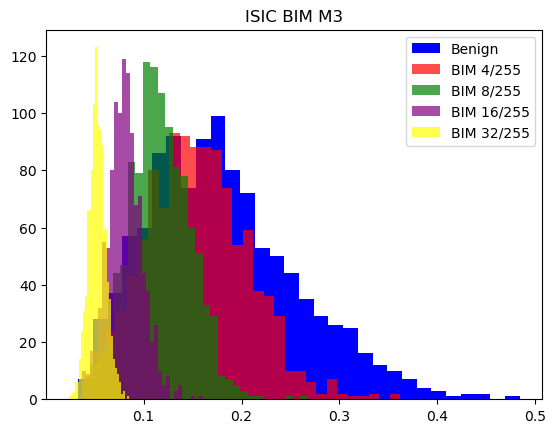

[0.10063463281958296, 0.10244786944696282, 0.09882139619220308, 0.09972801450589303]
[0.2638259292837715, 0.5847688123300091, 0.8476881233000907, 0.9655485040797824]


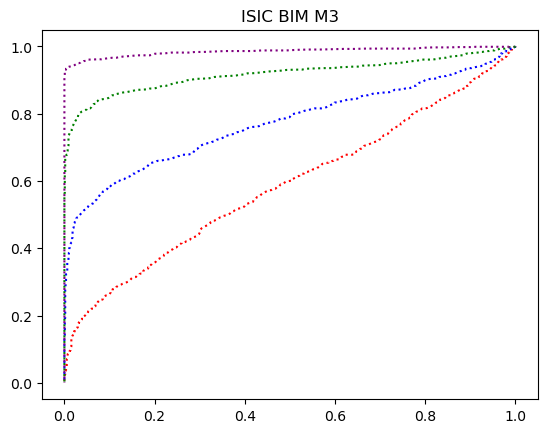

In [22]:
plt.title("ISIC BIM M3")
plt.hist(ben_res[0], label='Benign', color='blue', bins=30)
plt.hist(adv_res[0], label='BIM 4/255',color='red', alpha=0.7, bins=30)
plt.hist(adv_res[1], label='BIM 8/255',color='green', alpha=0.7, bins=30)
plt.hist(adv_res[2], label='BIM 16/255',color='purple', alpha=0.7, bins=30)
plt.hist(adv_res[3], label='BIM 32/255',color='yellow', alpha=0.7, bins=30)

plt.legend()
plt.show()
import roc_curve
x1, y1 = roc_curve.min_roc_curve(ben_res[0], adv_res[0], 1000)
x2, y2 = roc_curve.min_roc_curve(ben_res[1], adv_res[1], 1000)
x3, y3 = roc_curve.min_roc_curve(ben_res[2], adv_res[2], 1000)
x4, y4 = roc_curve.min_roc_curve(ben_res[3], adv_res[3], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.title("ISIC BIM M3")
plt.plot(x1, y1,   "red", linestyle = 'dotted', label = 'BIM 4/255')
plt.plot(x2, y2, "blue", linestyle = 'dotted', label = 'BIM 8/255')
plt.plot(x3, y3, "green", linestyle = 'dotted', label = 'BIM 16/255')
plt.plot(x4, y4, "purple", linestyle = 'dotted', label = 'BIM 32/255')
plt.show()

## x*grad

In [26]:
ben_res = [] 
adv_res = []
for eps in ep:
    x, y = run(model, val_loader, eps, "fgsm", "m1")
    ben_res.append(x)
    adv_res.append(y)

Attribution Complete
Attribution Complete
Attribution Complete
Attribution Complete


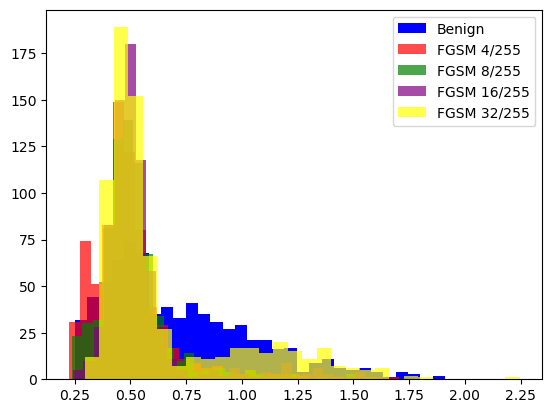

[0.0994550408719346, 0.0994550408719346, 0.0994550408719346, 0.09809264305177112]
[0.46321525885558584, 0.46321525885558584, 0.47002724795640327, 0.09400544959128065]


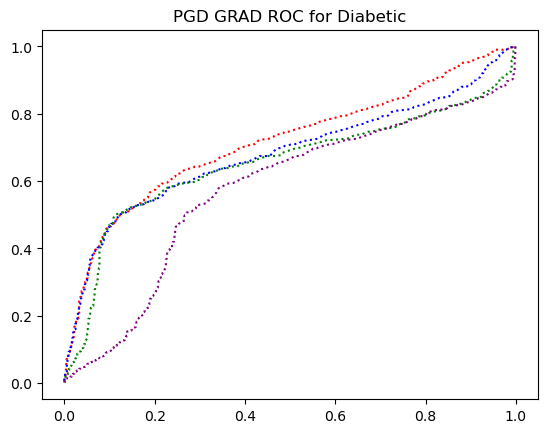

In [27]:
plt.hist(ben_res[0], label='Benign', color='blue', bins=30)
plt.hist(adv_res[0], label='FGSM 4/255',color='red', alpha=0.7, bins=30)
plt.hist(adv_res[1], label='FGSM 8/255',color='green', alpha=0.7, bins=30)
plt.hist(adv_res[2], label='FGSM 16/255',color='purple', alpha=0.7, bins=30)
plt.hist(adv_res[3], label='FGSM 32/255',color='yellow', alpha=0.7, bins=30)

plt.legend()
plt.show()
import roc_curve
x1, y1 = roc_curve.min_roc_curve(ben_res[0], adv_res[0], 1000)
x2, y2 = roc_curve.min_roc_curve(ben_res[1], adv_res[1], 1000)
x3, y3 = roc_curve.min_roc_curve(ben_res[2], adv_res[2], 1000)
x4, y4 = roc_curve.min_roc_curve(ben_res[3], adv_res[3], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.plot(x1, y1,   "red", linestyle = 'dotted', label = 'FGSM 4/255')
plt.plot(x2, y2, "blue", linestyle = 'dotted', label = 'FGSM 8/255')
plt.plot(x3, y3, "green", linestyle = 'dotted', label = 'FGSM 16/255')
plt.plot(x4, y4, "purple", linestyle = 'dotted', label = 'FGSM 32/255')
plt.show()

## GRAD

In [49]:
ben_res, adv_res = run(model, val_loader, ep[0], "fgsm", "grad")

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete
Attribution for batch 20 complete
Attribution for batch 21 complete
Attribution for batch 22 complete
Attribution for batch 23 complete
Attribution for batch 24 complete
Attribution for batch 25 complete
Attribution for batch 26 complete
Attribution for batch 27 complete
Attribution for batch 28 complete
Attribution for batch 29

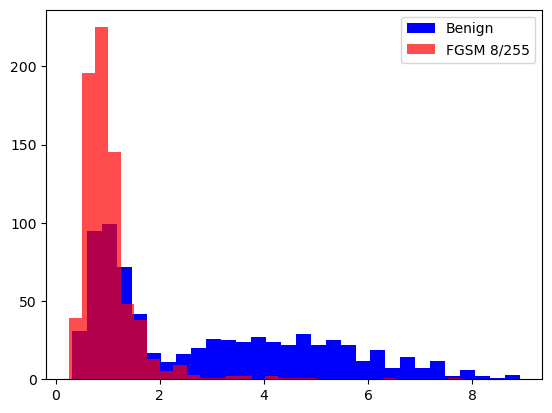

[0.0994550408719346, 0, 0, 0]
[0.5749318801089919, 0, 0, 0]


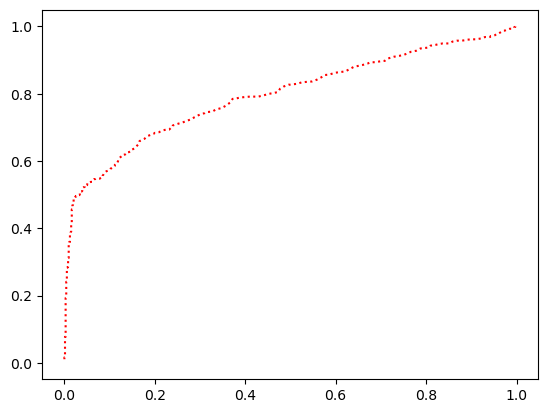

In [50]:
ind = 2
plt.hist(ben_res[ind], label='Benign', color='blue', bins=30)
plt.hist(adv_res[ind], label='FGSM 8/255',color='red', alpha=0.7, bins=30)


plt.legend()
plt.show()
import roc_curve
x1, y1 = roc_curve.min_roc_curve(ben_res[ind], adv_res[ind], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a in x1:
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.plot(x1, y1, "red", linestyle = 'dotted')
plt.show()

## Topk m1

In [18]:
def runk(model, val_loader, eps, attack, defense):
    gc.collect()
    torch.cuda.empty_cache()
    
    dataiter = iter(val_loader)
    
    meanAbs_bena = []
    meanAbs_ben = []
    
    for i in range(len(val_loader)):
        images, labels = next(dataiter)
        images = images.to(device)
        labels = labels.to(device)
        for ind in range(len(images)):
            gc.collect()
            torch.cuda.empty_cache()
            input = images[ind]
            
            _, y = model(input.unsqueeze(0)).max(1)
            
            if defense == "grad":
                ben = gradient(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "ig":
                ben = ig(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m1":
                ben = m1(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m2,1":
                ben = m2(model, input, 1, y).sum(axis=1).cpu().detach().numpy()
            
            ben = ben.flatten()
            ben = np.sort(ben)
            ben = ben[::-1]
            temp = []
            temp.append(ben[:100])

            meanAbs_ben += compute_mean_abs_dev(temp)
            
            if attack == "pgd":
                alpha = eps/10
                steps = 20
                input = projected_gradient_descent(model, input.unsqueeze(0), eps, alpha, steps, np.inf)[0]
            elif attack == "fgsm":
                input = fast_gradient_method(model, input.unsqueeze(0), eps, np.inf)[0]
            elif attack == "bim":
                alpha = eps/10
                steps = 20
                input = projected_gradient_descent(model, input.unsqueeze(0), eps, alpha, steps, np.inf, rand_init=False)[0]
            
            _, y = model(input.unsqueeze(0)).max(1)
            
            if defense == "grad":
                adv = gradient(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "ig":
                adv = ig(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m1":
                adv = m1(model, input, y).sum(axis=1).cpu().detach().numpy()
            elif defense == "m2,1":
                adv = m2(model, input, 1, y).sum(axis=1).cpu().detach().numpy()
                
            adv = adv.flatten()
            adv = np.sort(adv)
            adv = adv[::-1]
            temp = []
            temp.append(adv[:100])
                
            meanAbs_bena += compute_mean_abs_dev(temp)
            
            gc.collect()
            torch.cuda.empty_cache()
                   
    print("Attribution Complete")
    
    return meanAbs_ben, meanAbs_bena

In [19]:
ben_res = [] 
adv_res = []
for eps in ep:
    x, y = runk(model, val_loader, eps, "fgsm", "m1")
    ben_res.append(x)
    adv_res.append(y)

/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Attribution Complete
Attribution Complete
Attribution Complete
Attribution Complete


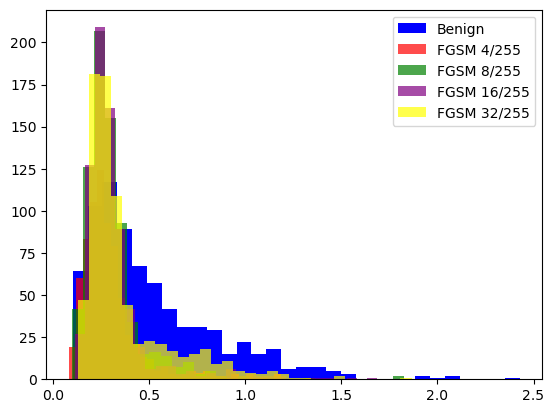

[0.1008174386920981, 0.0994550408719346, 0.10217983651226158, 0.0994550408719346]
[0.444141689373297, 0.4318801089918256, 0.45776566757493187, 0.22479564032697547]


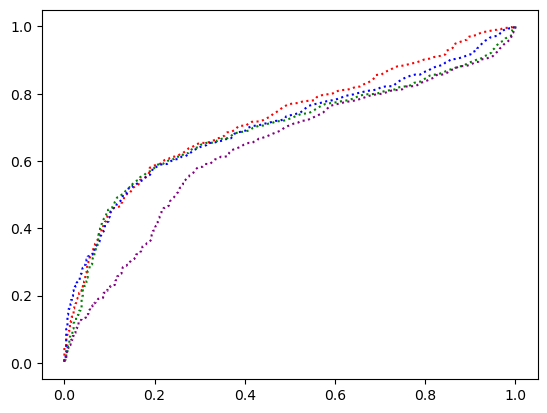

In [20]:
plt.hist(ben_res[0], label='Benign', color='blue', bins=30)
plt.hist(adv_res[0], label='FGSM 4/255',color='red', alpha=0.7, bins=30)
plt.hist(adv_res[1], label='FGSM 8/255',color='green', alpha=0.7, bins=30)
plt.hist(adv_res[2], label='FGSM 16/255',color='purple', alpha=0.7, bins=30)
plt.hist(adv_res[3], label='FGSM 32/255',color='yellow', alpha=0.7, bins=30)

plt.legend()
plt.show()
import roc_curve
x1, y1 = roc_curve.min_roc_curve(ben_res[0], adv_res[0], 1000)
x2, y2 = roc_curve.min_roc_curve(ben_res[1], adv_res[1], 1000)
x3, y3 = roc_curve.min_roc_curve(ben_res[2], adv_res[2], 1000)
x4, y4 = roc_curve.min_roc_curve(ben_res[3], adv_res[3], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.plot(x1, y1,   "red", linestyle = 'dotted', label = 'FGSM 4/255')
plt.plot(x2, y2, "blue", linestyle = 'dotted', label = 'FGSM 8/255')
plt.plot(x3, y3, "green", linestyle = 'dotted', label = 'FGSM 16/255')
plt.plot(x4, y4, "purple", linestyle = 'dotted', label = 'FGSM 32/255')
plt.show()

In [60]:
ben_res, adv_res = run(model, val_loader, ep[0], "fgsm", "m1")

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete
Attribution for batch 20 complete
Attribution for batch 21 complete
Attribution for batch 22 complete
Attribution for batch 23 complete
Attribution for batch 24 complete
Attribution for batch 25 complete
Attribution for batch 26 complete
Attribution for batch 27 complete
Attribution for batch 28 complete
Attribution for batch 29

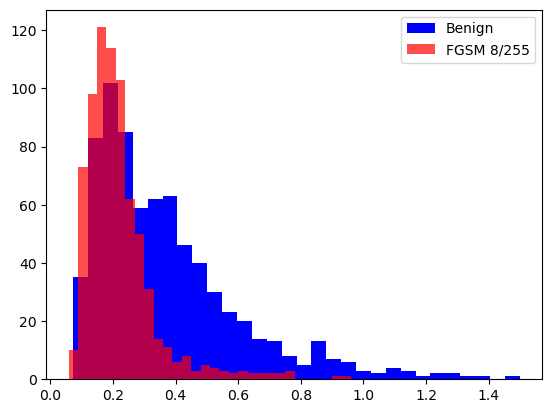

[0.1008174386920981, 0, 0, 0]
[0.46321525885558584, 0, 0, 0]


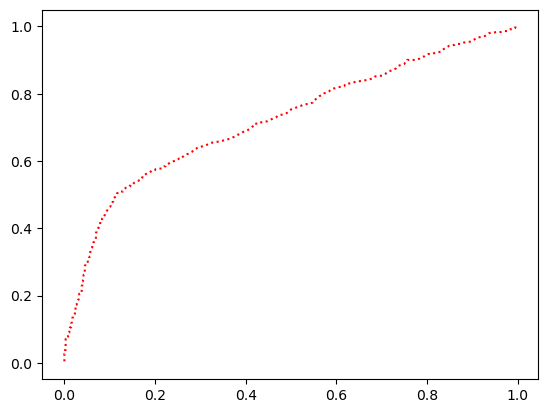

In [61]:
ind = 0
plt.hist(ben_res[ind], label='Benign', color='blue', bins=30)
plt.hist(adv_res[ind], label='FGSM 8/255',color='red', alpha=0.7, bins=30)


plt.legend()
plt.show()
import roc_curve
x1, y1 = roc_curve.min_roc_curve(ben_res[ind], adv_res[ind], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a in x1:
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.plot(x1, y1, "red", linestyle = 'dotted')
plt.show()

In [62]:
ben_res, adv_res = run(model, val_loader, ep[0], "fgsm", "m2,1")

Attribution for batch 0 complete
Attribution for batch 1 complete
Attribution for batch 2 complete
Attribution for batch 3 complete
Attribution for batch 4 complete
Attribution for batch 5 complete
Attribution for batch 6 complete
Attribution for batch 7 complete
Attribution for batch 8 complete
Attribution for batch 9 complete
Attribution for batch 10 complete
Attribution for batch 11 complete
Attribution for batch 12 complete
Attribution for batch 13 complete
Attribution for batch 14 complete
Attribution for batch 15 complete
Attribution for batch 16 complete
Attribution for batch 17 complete
Attribution for batch 18 complete
Attribution for batch 19 complete
Attribution for batch 20 complete
Attribution for batch 21 complete
Attribution for batch 22 complete
Attribution for batch 23 complete
Attribution for batch 24 complete
Attribution for batch 25 complete
Attribution for batch 26 complete
Attribution for batch 27 complete
Attribution for batch 28 complete
Attribution for batch 29

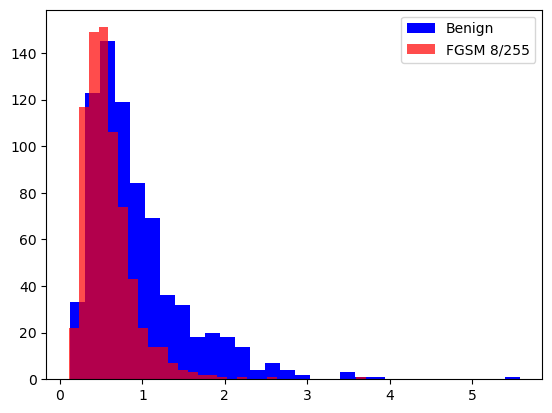

[0.09809264305177112, 0, 0, 0]
[0.3528610354223433, 0, 0, 0]


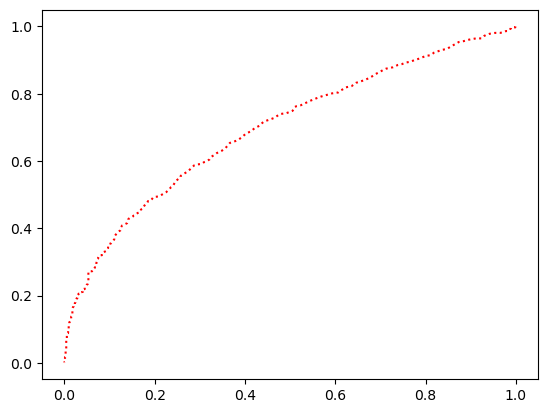

In [65]:
ind = 2
plt.hist(ben_res[ind], label='Benign', color='blue', bins=30)
plt.hist(adv_res[ind], label='FGSM 8/255',color='red', alpha=0.7, bins=30)


plt.legend()
plt.show()
import roc_curve
x1, y1 = roc_curve.min_roc_curve(ben_res[ind], adv_res[ind], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a in x1:
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.plot(x1, y1, "red", linestyle = 'dotted')
plt.show()

# Sensitivity

In [16]:
from skimage.util import random_noise

def m3(model, x, norm):
    x = x.detach()
    _, y = model(x.unsqueeze(0)).max(1)
    grad = gradient(model, x, y)
    x_not = x+grad
    x_not = x_not.detach()
    _, y_not = model(x_not.unsqueeze(0)).max(1)
    grad_not = gradient(model, x_not, y_not)
    return torch.cdist(grad, grad_not, norm).cpu().detach().numpy()[0][0]

In [17]:
def m4(model, x, norm):
    x = x.detach()
    _, y = model(x.unsqueeze(0)).max(1)
    grad = gradient(model, x, y)
    x_not = random_noise(x.cpu(), mode='gaussian')
    x_not = torch.from_numpy(x_not).to(device)
    x_not = x_not.type(torch.cuda.FloatTensor)
    _, y_not = model(x_not.unsqueeze(0)).max(1)
    grad_not = gradient(model, x_not, y_not)
    return torch.cdist(grad, grad_not, norm).cpu().detach().numpy()[0][0]

In [18]:
def run_m3(model, val_loader, eps, attack, defense):
    gc.collect()
    torch.cuda.empty_cache()
    
    dataiter = iter(val_loader)
    
    adv_res = []
    ben_res= []
    
    for i in range(len(val_loader)):
        images, labels = next(dataiter)
        images = images.to(device)
        labels = labels.to(device)
        for ind in range(len(images)):
            gc.collect()
            torch.cuda.empty_cache()
            input = images[ind]
            
            if defense == "m3,1":
                ben = m3(model, input, 1)
            elif defense == "m3,2":
                ben = m3(model, input, 2)
            elif defense == "m3,inf":
                ben = m3(model, input, np.inf)
                
            ben_res.append(ben)
            
            if attack == "pgd":
                alpha = eps/10
                steps = 20
                input = projected_gradient_descent(model, input.unsqueeze(0), eps, alpha, steps, np.inf, rand_init=False)[0]
            elif attack == "fgsm":
                input = fast_gradient_method(model, input.unsqueeze(0), eps, np.inf)[0]
            
            
            if defense == "m3,1":
                adv = m3(model, input, 1)
            elif defense == "m3,2":
                adv = m3(model, input, 2)
            elif defense == "m3,inf":
                adv = m3(model, input, np.inf)
                
            adv_res.append(adv)
            
            gc.collect()
            torch.cuda.empty_cache()
                   
    print("Attribution Complete")
    
    return ben_res, adv_res

In [19]:
gc.collect()
torch.cuda.empty_cache()

ben_res = [] 
adv_res = []
for eps in ep:
    gc.collect()
    torch.cuda.empty_cache()
    x, y = run_m3(model, val_loader, eps, "pgd", "m3,inf")
    ben_res.append(x)
    adv_res.append(y)

/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Attribution Complete
Attribution Complete
Attribution Complete
Attribution Complete


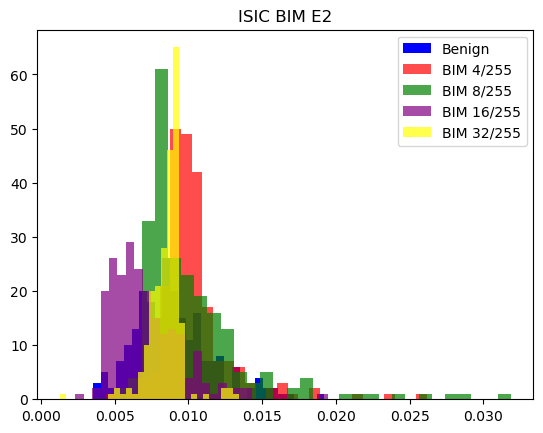

[0.09821428571428571, 0.09821428571428571, 0.09821428571428571, 0.08928571428571429]
[0.45535714285714285, 0.29464285714285715, 0.26339285714285715, 0.375]


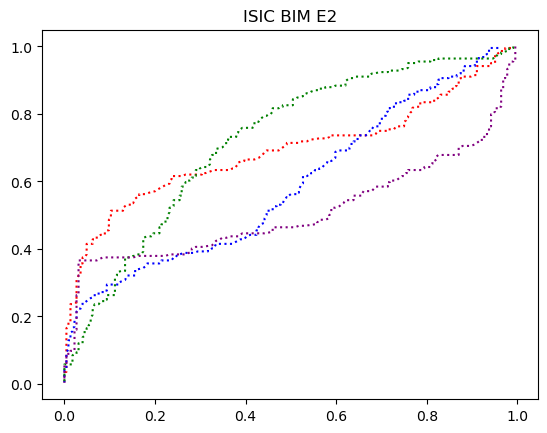

In [22]:
plt.title("ISIC BIM E2")
plt.hist(ben_res[0][0], label='Benign', color='blue', bins=30)
plt.hist(adv_res[0][0], label='BIM 4/255',color='red', alpha=0.7, bins=30)
plt.hist(adv_res[1][0], label='BIM 8/255',color='green', alpha=0.7, bins=30)
plt.hist(adv_res[2][0], label='BIM 16/255',color='purple', alpha=0.7, bins=30)
plt.hist(adv_res[3][0], label='BIM 32/255',color='yellow', alpha=0.7, bins=30)

plt.legend()
plt.show()
import roc_curve
x1, y1 = roc_curve.max_roc_curve(ben_res[0][0], adv_res[0][0], 1000)
x2, y2 = roc_curve.max_roc_curve(ben_res[1][0], adv_res[1][0], 1000)
x3, y3 = roc_curve.min_roc_curve(ben_res[2][0], adv_res[2][0], 1000)
x4, y4 = roc_curve.min_roc_curve(ben_res[3][0], adv_res[3][0], 1000)

fpr_res = [0, 0, 0, 0]
tpr_res = [0, 0, 0, 0]
i = 0
for a, b, c, d in zip(x1, x2, x3, x4):
    if abs(a - 0.1) < abs(fpr_res[0] - 0.1):
        fpr_res[0] = a
        tpr_res[0] = y1[i]
    if abs(b - 0.1) < abs(fpr_res[1] - 0.1):
        fpr_res[1] = b
        tpr_res[1] = y2[i]
    if abs(c - 0.1) < abs(fpr_res[2] - 0.1):
        fpr_res[2] = c
        tpr_res[2] = y3[i]
    if abs(d - 0.1) < abs(fpr_res[3] - 0.1):
        fpr_res[3] = d
        tpr_res[3] = y4[i]
    i+=1
        
print(fpr_res)
print(tpr_res)

plt.title("ISIC BIM E2")
plt.plot(x1, y1, "red", linestyle = 'dotted', label = 'PGD 4/255')
plt.plot(x2, y2, "blue", linestyle = 'dotted', label = 'PGD 8/255')
plt.plot(x3, y3, "green", linestyle = 'dotted', label = 'PGD 16/255')
plt.plot(x4, y4, "purple", linestyle = 'dotted', label = 'PGD 32/255')
plt.show()